In [581]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from os.path import exists, join
import os
import xarray as xr
import pandas as pd
from glob import glob
import sys
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LogNorm
from IPython.display import Image
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC, DistributedReliability
from hagelslag.evaluation.MetricPlotter import roc_curve, performance_diagram, attributes_diagram
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Input, Conv1D
from keras.layers import Activation, Reshape, LeakyReLU, concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.utils import class_weight
from sklearn.svm import SVC
from deepsky.gan import rescale_multivariate_data, rescale_data
from scipy.stats import percentileofscore
from sklearn.cluster import KMeans
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "6"


# Data Loading
Load storm patch data from every file.

In [ ]:
def load_storm_patch_data(data_path, variable_names):
    data_patches = []
    centers = []
    valid_dates = []
    data_files = sorted(glob(join(data_path, "*.nc")))
    for data_file in data_files:
        print(data_file)
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        if np.all(np.in1d(variable_names, all_vars)):
            centers.append(np.array([ds["longitude"][:, 32, 32], ds["latitude"][:, 32, 32]]).T)
            valid_dates.append(ds["valid_date"].values)
            for variable in variable_names:
                patch_arr.append(ds[variable][:, 16:-16, 16:-16].values)
            data_patches.append(np.stack(patch_arr, axis=-1))
        ds.close()
    center_arr = np.vstack(centers)
    valid_date_index = pd.DatetimeIndex(np.concatenate(valid_dates))
    data = np.vstack(data_patches)
    return data, center_arr, valid_date_index

In [4]:
data = xr.open_dataset("/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_09.nc")

In [5]:
all_vars = list(data.variables.keys())
variable_names = ['composite_reflectivity_entire_atmosphere_current',
                  'precipitable_water_entire_atmosphere_(considered_as_a_single_layer)_current',
                  'geopotential_height_level_of_adiabatic_condensation_from_sfc_prev',
                  'convective_available_potential_energy_180-0_mb_above_ground_prev',
                  'vertical_u-component_shear_0-6000_m_above_ground_prev',
                  'vertical_v-component_shear_0-6000_m_above_ground_prev',
                  ]
np.all(np.in1d(variable_names, all_vars))

True

In [7]:
storm_data, storm_centers, storm_dates = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", variable_names)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc
/scr

In [8]:
storm_reports = pd.read_csv("http://www.spc.noaa.gov/wcm/data/2016_hail.csv", parse_dates={"datetime":["date", "time"]})
severe_reports = storm_reports.loc[storm_reports["mag"] >= 1]
severe_reports = severe_reports.reset_index()

In [36]:
severe_reports.columns

Index(['datetime', 'om', 'yr', 'mo', 'dy', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4'],
      dtype='object')

In [9]:
def gc_distance(lon_1, lat_1, lon_2, lat_2):
    inv_lat_1 = np.radians(90 - lat_1)
    inv_lat_2 = np.radians(90 - lat_2)
    lon_1_rad = np.radians(lon_1)
    lon_2_rad = np.radians(lon_2)
    radius = 6373.0
    arc = np.arccos(np.sin(inv_lat_1) * np.sin(inv_lat_2) * np.cos(lon_1_rad - lon_2_rad) + np.cos(inv_lat_1) * np.cos(inv_lat_2))
    return radius * arc

In [11]:
severe_reports.shape

(7269, 28)

In [12]:
tdiff = pd.TimedeltaIndex(np.abs(severe_reports["datetime"].values - np.datetime64(storm_dates[0])))
tdiff.total_seconds() / 3600

array([ 2779.05      ,  2779.        ,  2779.        , ...,  5739.36666667,
        5740.41666667,  5740.65      ])

In [14]:
has_severe_hail = np.zeros(storm_dates.size, dtype=np.int16)
min_severe_hail_distance = np.ones(storm_dates.size, dtype=np.float32) * np.nan
min_times = np.ones(storm_dates.size, dtype=np.float32)
for s in range(has_severe_hail.size):
    tdiff = pd.TimedeltaIndex(np.abs(severe_reports["datetime"].values - np.datetime64(storm_dates.values[s])))
    valid_times = np.where((tdiff.total_seconds() / 3600) < 4)[0]
    min_times[s] = (tdiff.total_seconds() / 3600).min()
    if len(valid_times) > 0:
        report_distances = gc_distance(storm_centers[s, 0], 
                                       storm_centers[s, 1], 
                                       severe_reports.loc[valid_times, "slon"], 
                                       severe_reports.loc[valid_times, "slat"])
        has_severe_hail[s] = np.count_nonzero(report_distances < 160)
        min_severe_hail_distance[s] = report_distances.min()

In [16]:
storm_patch_label_frame = pd.DataFrame({"lon": storm_centers[:, 0], 
                                        "lat": storm_centers[:, 1], 
                                        "valid_time": storm_dates,
                                        "report_count":has_severe_hail, 
                                        "min_severe_hail_distance": min_severe_hail_distance, 
                                         "min_time": min_times}, 
                                         columns=["valid_time", "lon", "lat", 
                                                  "report_count", "min_severe_hail_distance", "min_time"])
storm_patch_label_frame.to_csv("/scratch/dgagne/hail_models/hail_distance_labels.csv", index=False)

In [17]:
np.nanpercentile(min_severe_hail_distance, [10, 25, 50, 75, 90])

array([   82.33264465,   168.22813416,   352.41934204,   760.2444458 ,
        1312.76967773])

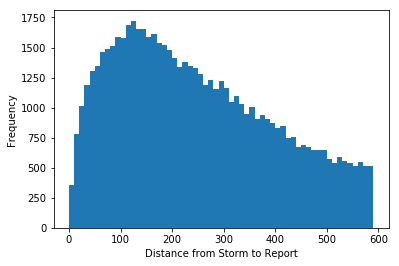

In [18]:
plt.hist(min_severe_hail_distance[~np.isnan(min_severe_hail_distance)], 
         bins=np.arange(0, 600, 10), cumulative=False)
plt.xlabel("Distance from Storm to Report")
plt.ylabel("Frequency")

(array([ 62031.,  13004.,  10274.,   8643.,   7649.,   5215.,   2950.,
          1713.,   1170.,    463.]),
 array([  0.        ,   1.0583333 ,   2.1166666 ,   3.1749999 ,
          4.23333321,   5.29166651,   6.34999981,   7.40833311,
          8.46666641,   9.52499971,  10.58333302]),
 <a list of 10 Patch objects>)

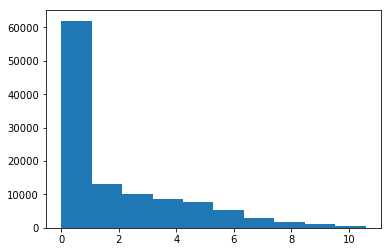

In [19]:
plt.hist(min_times)

In [20]:
for c in [2, 3]:
    storm_data[:, :, :, c] = np.sqrt(storm_data[:, :, :, c])

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


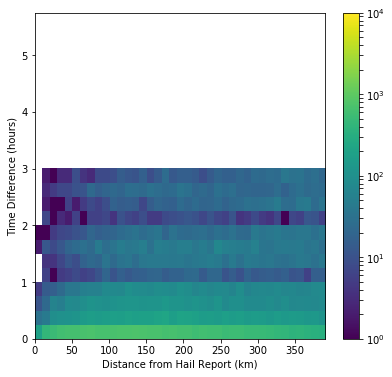

In [26]:
plt.figure(figsize=(6.5, 6))
plt.hist2d(min_severe_hail_distance, min_times, 
           bins=[np.arange(0, 400, 10), np.arange(0, 6, 0.25)], 
           norm=LogNorm(vmin=1, vmax=10000),cmin=1)
plt.colorbar()
plt.gca().set(xlabel="Distance from Hail Report (km)", ylabel="Time Difference (hours)")

In [157]:
np.nanpercentile(min_severe_hail_distance, 10)

81.685311658436007

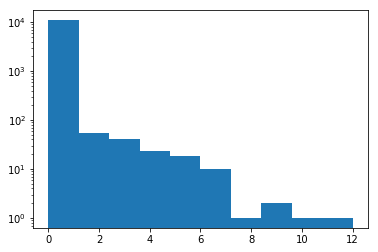

In [158]:
plt.hist(has_severe_hail)
plt.gca().set_yscale("log")

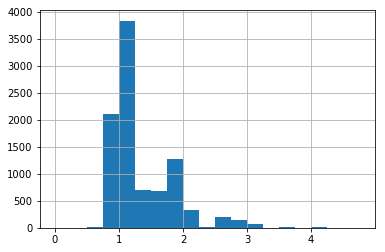

In [32]:
storm_reports["mag"].hist(bins=np.arange(0, 5, 0.25))

(array([ 17372801.,   7066324.,  12435941.,  18136456.,  19860252.,
         23683962.,  12010503.,   4148522.,   1043929.,     67998.]),
 array([-20.    ,  -9.6875,   0.625 ,  10.9375,  21.25  ,  31.5625,
         41.875 ,  52.1875,  62.5   ,  72.8125,  83.125 ]),
 <a list of 10 Patch objects>)

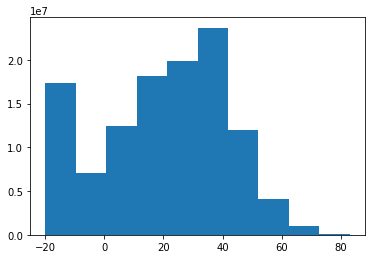

In [23]:
plt.hist(storm_data[:, :, :, 0].ravel())

In [32]:
storm_data[:, :, :, 4].mean()

3.8873699

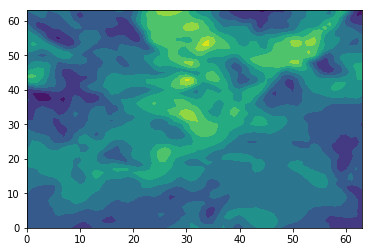

In [83]:
plt.contourf(storm_data[355, :, :, 1])

In [24]:
unique_storm_dates = np.unique(storm_dates.date)
shuffled_storm_dates = np.random.permutation(unique_storm_dates)
split_point = int(0.7 * len(shuffled_storm_dates))
train_dates = np.sort(shuffled_storm_dates[:split_point])
test_dates = np.sort(shuffled_storm_dates[split_point:])
train_indices = np.where(np.in1d(storm_dates.date, train_dates))[0]
test_indices = np.where(np.in1d(storm_dates.date, test_dates))[0]

In [25]:
min_severe_hail_distance[np.isnan(min_severe_hail_distance)] = 9999999
train_labels = np.where(min_severe_hail_distance[train_indices] < 160, 1, 0)
test_labels = np.where(min_severe_hail_distance[test_indices] < 160, 1, 0)

In [437]:
with open("/scratch/dgagne/hail_models/train_dates.pkl", "wb") as train_date_file:
    pickle.dump(train_dates, train_date_file)
with open("/scratch/dgagne/hail_models/test_dates.pkl", "wb") as test_date_file:
    pickle.dump(test_dates, test_date_file)

In [27]:
pc_objs = []
means = []
sds = []
num_comps = 10
num_vars = storm_data.shape[-1]
pc_train_data = np.zeros((train_indices.size, num_comps * num_vars), dtype=np.float32)
pc_test_data = np.zeros((test_indices.size, num_comps * num_vars), dtype=np.float32)
for v in range(num_vars):
    print(v)
    pc_objs.append(PCA(n_components=10))
    var_data = storm_data[:, :, :, v].reshape(-1, storm_data.shape[1] * storm_data.shape[2])
    means.append(var_data.mean())
    sds.append(var_data.std())
    norm_data = (var_data - means[v]) / sds[v]
    pc_train_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].fit_transform(norm_data[train_indices])
    pc_test_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].transform(norm_data[test_indices])

0
1
2
3
4
5


In [28]:
for p, pc_obj in enumerate(pc_objs):
    with open("/scratch/dgagne/hail_models/pc_obj_{0:d}.pkl".format(p), "wb") as pc_file:
        pickle.dump(pc_obj, pc_file, protocol=pickle.HIGHEST_PROTOCOL)

(array([  8.40000000e+01,   4.02000000e+02,   2.82400000e+03,
          4.32840000e+04,   3.86942800e+06,   2.65179470e+07,
          2.74679710e+07,   3.54791740e+07,   4.25210630e+07,
          4.77017180e+07,   5.11830660e+07,   5.36286590e+07,
          5.30860510e+07,   4.49446320e+07,   3.22885810e+07,
          2.24033460e+07,   1.41050390e+07,   6.10807300e+06,
          1.80974900e+06,   1.45661000e+05]),
 array([ 3.7516489 ,  3.99670758,  4.24176626,  4.48682494,  4.73188362,
         4.9769423 ,  5.22200098,  5.46705966,  5.71211834,  5.95717702,
         6.2022357 ,  6.44729438,  6.69235306,  6.93741174,  7.18247042,
         7.4275291 ,  7.67258778,  7.91764646,  8.16270514,  8.40776381,
         8.65282249]),
 <a list of 20 Patch objects>)

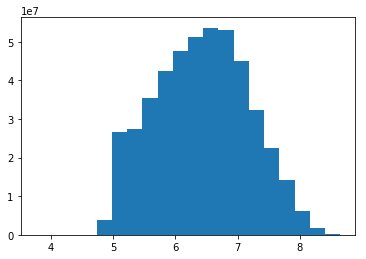

In [47]:
plt.hist(np.log(storm_data[:, :, :, 2].ravel()), bins=20)

In [29]:
short_var_names = ["Reflectivity", "Precipitable Water", "LCL Height", "CAPE", "0-6 km Shear-U", "0-6 km Shear-V"]

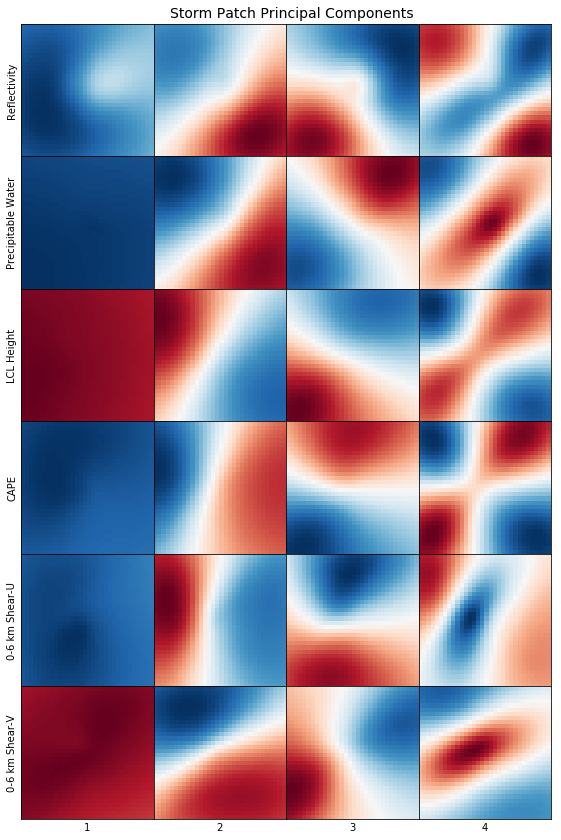

In [430]:
vis_comps = 4
fig, axes = plt.subplots(num_vars, vis_comps, figsize=(8, 12))
plt.subplots_adjust(0.03, 0.03, 0.95, 0.95, wspace=0, hspace=0)
#cax = fig.add_axes([0.96, 0.04, 0.03, 0.9])
p_ex = np.round(np.max([np.maximum(np.abs(pc_obj.components_.min()), 
                                  pc_obj.components_.max()) for pc_obj in pc_objs]),2)
for p, pc_obj in enumerate(pc_objs):
    for v in range(vis_comps):
        p_ex = np.round(np.max(np.abs(pc_obj.components_[v])), decimals=4)
        cont = axes[p, v].pcolormesh(pc_obj.components_[v].reshape(32, 32), 
                                     cmap="RdBu_r", vmin=-p_ex, vmax=p_ex)
        axes[p, v].axes.get_xaxis().set_ticks([])
        axes[p, v].axes.get_yaxis().set_ticks([])
        axes[-1, v].set(xlabel=v + 1)
    axes[p, 0].set(ylabel=short_var_names[p])
#cbar = fig.colorbar(cont, cax=cax)
#cbar.ax.tick_params(labelsize=12)
fig.suptitle("Storm Patch Principal Components", y=0.97, fontsize=14)
plt.savefig("/scratch/dgagne/hail_models/storm_patch_pca.png", dpi=250, bbox_inches="tight")

In [40]:
pc_objs[5].explained_variance_ratio_

array([ 0.64380208,  0.08320423,  0.05229771,  0.03013456,  0.02144564,
        0.01347508,  0.01136129,  0.00994684,  0.00812216,  0.00718102])

In [42]:
mv_means = []
mv_sds = []
mv_num_comps = 15
mv_num_vars = storm_data.shape[-1]
mv_pc_obj = PCA(n_components=mv_num_comps)
mv_pc_train_data = np.zeros((train_indices.size, mv_num_comps), dtype=np.float32)
mv_pc_test_data = np.zeros((test_indices.size, mv_num_comps), dtype=np.float32)
mv_norm_data = np.zeros((storm_data.shape[0], 64 * 64 * num_vars), dtype=np.float32)
for v in range(mv_num_vars):
    print(v)
    #if v == 2:
    #    var_data = np.sqrt(storm_data[:, :, :, v].reshape(-1, 64 * 64))
    #else:
    var_data = storm_data[:, :, :, v].reshape(-1, storm_data.shape[1] * storm_data.shape[2])
    mv_means.append(var_data.mean())
    mv_sds.append(var_data.std())
    mv_norm_data[:, 32 * 32 * v: 32 * 32 * (v + 1)] = (var_data - means[v]) / sds[v]
mv_pc_train_data[:, :] = mv_pc_obj.fit_transform(mv_norm_data[train_indices])
mv_pc_test_data[:, :] = mv_pc_obj.transform(mv_norm_data[test_indices])

0
1
2
3
4
5


In [60]:
mv_pc_obj.components_[0, 0:4096]

array([-0.00144565, -0.00145403, -0.00144767, ..., -0.00298122,
       -0.00299205, -0.00300172])

0.06
0 0 0.0073
0 1 0.015
0 2 0.0082
0 3 0.0121
1 0 0.023
1 1 0.0058
1 2 0.0073
1 3 0.0091
2 0 0.0219
2 1 0.0123
2 2 0.0067
2 3 0.0157
3 0 0.0137
3 1 0.0222
3 2 0.0127
3 3 0.0218
4 0 0.0054
4 1 0.0123
4 2 0.033
4 3 0.0034
5 0 0.0015
5 1 0.024
5 2 0.0093
5 3 0.0237


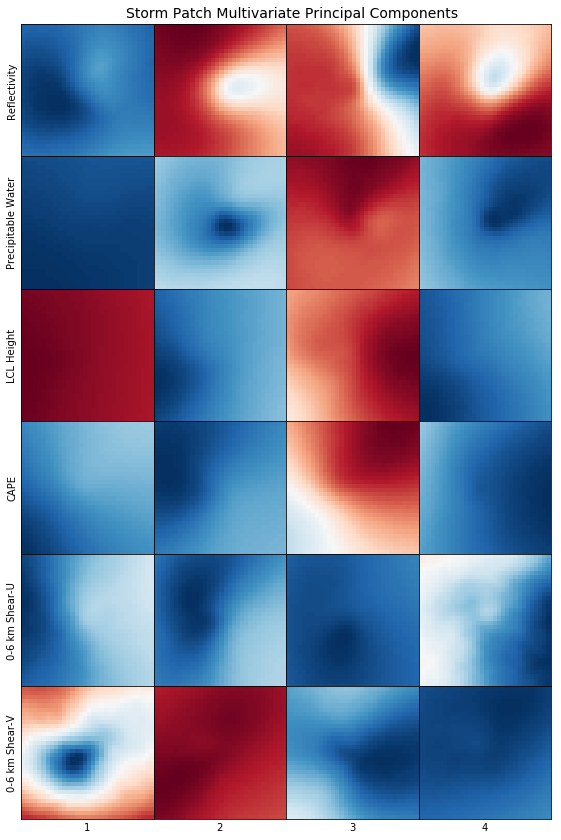

In [427]:
vis_comps = 4
fig, axes = plt.subplots(num_vars, vis_comps, figsize=(8, 12))
plt.subplots_adjust(0.03, 0.03, 0.95, 0.95, wspace=0, hspace=0)
p_ex = np.round(np.maximum(np.abs(mv_pc_obj.components_.min()), np.abs(mv_pc_obj.components_.max())), decimals=2)
print(p_ex)
#cax = fig.add_axes([0.96, 0.04, 0.03, 0.9])
for p in range(mv_num_vars):
    for v in range(vis_comps):
        pc_grid = mv_pc_obj.components_[v, 32 **2 * p: 32**2 * (p + 1)].reshape(32, 32)
        p_ex = np.round(np.max(np.abs(pc_grid)), decimals=4)
        print(p, v, p_ex)
        cont = axes[p, v].pcolormesh(pc_grid, 
                                   #np.linspace(-np.round(p_ex,2), np.round(p_ex, 2), 51), cmap="RdBu_r")
                                     vmin=-p_ex, vmax=p_ex, cmap="RdBu_r")
        axes[p, v].axes.get_xaxis().set_ticks([])
        axes[p, v].axes.get_yaxis().set_ticks([])
        axes[-1, v].set(xlabel=v + 1)
    axes[p, 0].set(ylabel=short_var_names[p])
#cbar = fig.colorbar(cont, cax=cax)
#cbar.ax.tick_params(labelsize=14)
fig.suptitle("Storm Patch Multivariate Principal Components", y=0.97, fontsize=14)
plt.savefig("/scratch/dgagne/hail_models/storm_patch_mv_pca.png", dpi=250, bbox_inches="tight")

In [428]:
with open("/scratch/dgagne/hail_models/mv_pc_obj.pkl", "wb") as mv_pc_file:
    pickle.dump(mv_pc_obj, mv_pc_file, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
mv_pc_obj.explained_variance_ratio_.cumsum()

array([ 0.25121981,  0.4116815 ,  0.53017828,  0.59428162,  0.64458871,
        0.68168505,  0.70307494,  0.72366048,  0.7396714 ,  0.75486835,
        0.76818766,  0.77822378,  0.78806537,  0.79629753,  0.80346482])

In [46]:
rf_mv = RandomForestClassifier(n_estimators=500, n_jobs=6, max_features="sqrt")
rf_mv.fit(mv_pc_train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=6, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [47]:
rf_mv.feature_importances_

array([ 0.07926254,  0.08040495,  0.08485762,  0.09134354,  0.06118075,
        0.08807621,  0.05986307,  0.06023304,  0.05657487,  0.05658405,
        0.05703921,  0.05559512,  0.05868964,  0.05617851,  0.05411688])

In [48]:
rf_mv_preds = rf_mv.predict_proba(mv_pc_test_data)[:, 1]

In [49]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=6, max_features="sqrt")
rf.fit(pc_train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=6, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [50]:
rf_preds = rf.predict_proba(pc_test_data)[:, 1]

In [429]:
pickle.dump(rf, open("/scratch/dgagne/hail_models/hail_rf.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(rf_mv, open("/scratch/dgagne/hail_models/hail_rf_mv.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(logit, open("/scratch/dgagne/hail_models/hail_logit.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(logit_mv, open("/scratch/dgagne/hail_models/hail_logit_mv.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

(array([  7.46700000e+03,   8.47100000e+03,   6.78700000e+03,
          5.17700000e+03,   3.29800000e+03,   1.71600000e+03,
          6.64000000e+02,   2.07000000e+02,   4.90000000e+01,
          6.00000000e+00]),
 array([ 0.    ,  0.0706,  0.1412,  0.2118,  0.2824,  0.353 ,  0.4236,
         0.4942,  0.5648,  0.6354,  0.706 ]),
 <a list of 10 Patch objects>)

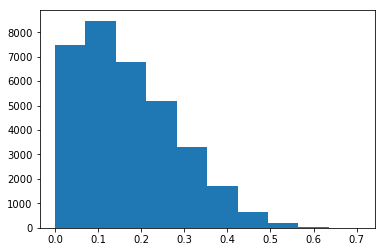

In [100]:
plt.hist(rf_preds)

In [51]:
logit_mv = LogisticRegression(penalty="l1")
logit_mv.fit(mv_pc_train_data, train_labels)
logit_mv_preds = logit_mv.predict_proba(mv_pc_test_data)[:, 1]

In [52]:
logit = LogisticRegression(penalty="l1")
logit.fit(pc_train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
logit_preds = logit.predict_proba(pc_test_data)[:, 1]

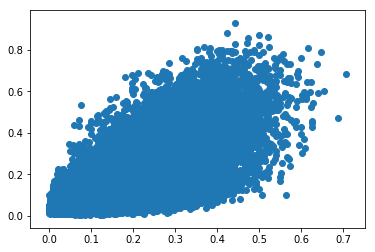

In [202]:
plt.scatter(rf_preds, logit_preds)

In [34]:
logit.coef_

array([[ 0.00410254, -0.00206951, -0.00654126,  0.00235539, -0.00701154,
         0.00216319, -0.00476771,  0.00142651,  0.00610242, -0.00016836,
         0.01656552,  0.02712975,  0.00357492,  0.0206493 ,  0.02383388,
        -0.01684514, -0.00341637,  0.0062114 , -0.00365573, -0.00946042,
         0.01847374, -0.00182606,  0.00297849,  0.00362054, -0.01020593,
         0.01486102, -0.00443039, -0.00279718, -0.00404756,  0.00174898,
        -0.00894072,  0.00694267,  0.00787597, -0.00852641, -0.00061422,
         0.00285988,  0.00311282,  0.00044144,  0.00055422,  0.00997964,
         0.0040147 ,  0.0025486 ,  0.00763022, -0.00820168,  0.01043601,
         0.00249809,  0.00232485, -0.00380224, -0.0044822 , -0.00505782]])

In [554]:
thresholds = np.array([0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
pred_list = [rf_preds, rf_mv_preds, logit_preds, logit_mv_preds, cnn_preds, ann_preds, gan_logit_preds]
rel_list = []
roc_list = []
for pred in pred_list:
    rel_list.append(DistributedReliability(thresholds=thresholds))
    rel_list[-1].update(pred, test_labels)
    roc_list.append(DistributedROC(thresholds=thresholds))
    roc_list[-1].update(pred, test_labels)
print([rel.brier_skill_score() for rel in rel_list])
print([roc.auc() for roc in roc_list])

[0.026433817311898946, 0.0053347958920198614, 0.024564869508950864, 0.030646034807289096, 0.03647295412627348, -0.029307627172520431, 0.02956408101745258]
[0.68801670136897608, 0.69188291374894917, 0.71219378083610541, 0.71127431645321726, 0.6880244146165978, 0.69299355314764588, 0.71167001288209364]


In [597]:
rel = rel_list[0]
rel.brier_score_components()

(0.0045216460716312242, 0.0076600430996052876, 0.1187265914318528)

In [599]:
for r, rel in enumerate(rel_list):
    print(rel.brier_score_components())

(0.0045216460716312242, 0.0076600430996052876, 0.1187265914318528)
(0.0069569034598595926, 0.0075902855921037614, 0.1187265914318528)
(0.006702025110225618, 0.0096185283359916055, 0.1187265914318528)
(0.0058773080821712424, 0.0095158073357425946, 0.1187265914318528)
(0.0044309980217914482, 0.0087613075446542291, 0.1187265914318528)
(0.012205131296092804, 0.0087255366189439038, 0.1187265914318528)
(0.0067528374415272742, 0.010262880009544562, 0.1187265914318528)


In [556]:
pred_frame = pd.DataFrame(np.array([rf_preds, rf_mv_preds, logit_preds, logit_mv_preds, cnn_preds, ann_preds, gan_logit_preds]).T,
                          columns=ml_model_names)

In [515]:
paired_preds = pred_frame.iloc[:, [0, 4]]
paired_preds.values[np.arange(0, 34238), np.random.randint(0,1, size=paired_preds.shape[0])]

array([ 0.082,  0.122,  0.102, ...,  0.166,  0.118,  0.074])

In [516]:
def brier_score(pred, label):
    return np.mean((pred - label) ** 2)
ref_model = "Conv. Net"
num_permutations = 10000
bs_diff_dist = np.zeros((pred_frame.columns.size, num_permutations), dtype=np.float32)
bs_diffs = np.zeros(pred_frame.columns.size, dtype=np.float32)
for m, model in enumerate(pred_frame.columns):
    if model != ref_model:
        paired_preds = pred_frame[[model, ref_model]]
        shuffled_preds = np.zeros(paired_preds.shape, dtype=np.float32)
        bs_diffs[m] = brier_score(paired_preds[ref_model], test_labels) - brier_score(paired_preds[model], test_labels)
        #print(bs_diff)
        for p in range(num_permutations):
            flips = np.random.randint(0, 2, size=paired_preds.shape[0])
            shuffled_preds[:, 0] = paired_preds.values[np.arange(paired_preds.shape[0]), flips]
            shuffled_preds[:, 1] = paired_preds.values[np.arange(paired_preds.shape[0]), 1-flips]
            bs_diff_dist[m, p] = brier_score(shuffled_preds[:, 0], test_labels) - brier_score(shuffled_preds[:, 1], test_labels)
        print(model, bs_diffs[m], percentileofscore(bs_diff_dist, bs_diffs[m], "mean"))  

Random Forest PCA -0.00223702 0.0
Random Forest MV PCA -0.00490137 0.0
Logistic Reg. PCA -0.00258304 0.0
Logistic Reg. MV PCA -0.00187859 0.0
Dense Net MV PCA -0.00843748 0.0
Logitic Reg. GAN -0.00495824 0.0


In [520]:
for model in pred_frame.columns:
    bs_model = brier_score(pred_frame[model], test_labels)
    print("{0:25s}".format(model), "{0:0.4f}".format(bs_model), "{0:0.4f}".format(1 - bs_model / bs_climo))

Random Forest PCA         0.1221 0.0250
Random Forest MV PCA      0.1247 0.0037
Logistic Reg. PCA         0.1224 0.0223
Logistic Reg. MV PCA      0.1217 0.0279
Conv. Net                 0.1198 0.0429
Dense Net MV PCA          0.1283 -0.0245
Logitic Reg. GAN          0.1248 0.0033


In [449]:
climo_preds = np.ones(test_labels.size) * train_labels.mean()
bs_climo = brier_score(climo_preds, test_labels)

In [458]:
1 / 60.0

0.016666666666666666

In [461]:
np.where(rf.feature_importances_ - 1.0/60 > 0)

(array([ 0,  1,  2,  4, 10, 11, 20, 21, 30, 31, 32, 40, 41, 50]),)

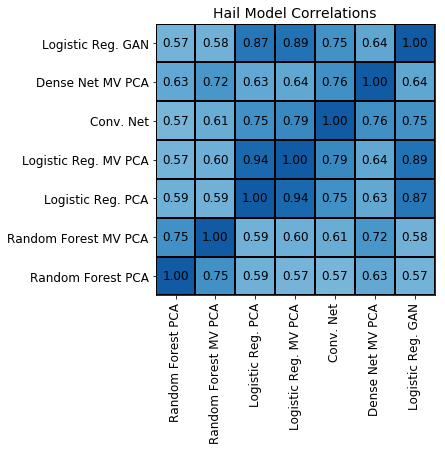

In [557]:
plt.figure(figsize=(5, 5))
r2_pred = np.corrcoef(pred_frame.values.T) ** 2
plt.pcolormesh(r2_pred, vmin=0, vmax=1.2, cmap="Blues", edgecolors="k")
plt.xticks(np.arange(7) + 0.5, ml_model_names, rotation=90, fontsize=12)
plt.yticks(np.arange(7) + 0.5, ml_model_names, rotation=0, fontsize=12)
for (i, j), v in np.ndenumerate(r2_pred):
    plt.text(i + 0.5, j + 0.5, "{0:0.2f}".format(v), ha="center", va="center", fontsize=12)
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.title("Hail Model Correlations", fontsize=14)
plt.savefig("/scratch/dgagne/hail_models/hail_model_corr.png", dpi=250, bbox_inches="tight")

In [558]:
ml_model_names = ["Random Forest PCA", 
                  "Random Forest MV PCA", 
                  "Logistic Reg. PCA",
                  "Logistic Reg. MV PCA",
                  "Conv. Net",
                  "Dense Net MV PCA",
                  "Logistic Reg. GAN"]
ml_model_colors = ["red", "pink", "blue", "cyan", "purple", "magenta", "skyblue"]
ml_model_symbols = ["o", "o", "v", "v", "s", "s", "v"]
roc_curve(roc_list, ml_model_names, ml_model_colors, ml_model_symbols, "/scratch/dgagne/hail_models/hail_prob_roc.png", figsize=(6, 6), 
          title="NCAR Storm Patch Severe Hail Probability ROC Curve")
performance_diagram(roc_list, ml_model_names, ml_model_colors, ml_model_symbols, "/scratch/dgagne/hail_models/hail_prob_perf.png", figsize=(6, 6), 
          title="NCAR Storm Patch Severe Hail Probability Performance Curve")

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/hagelslag-0.2-py3.5.egg/hagelslag/evaluation/MetricPlotter.py:122: RuntimeWarning: divide by zero encountered in true_divide
  bias = pod_g / sr_g
/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/hagelslag-0.2-py3.5.egg/hagelslag/evaluation/MetricPlotter.py:122: RuntimeWarning: invalid value encountered in true_divide
  bias = pod_g / sr_g
/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/hagelslag-0.2-py3.5.egg/hagelslag/evaluation/MetricPlotter.py:123: RuntimeWarning: divide by zero encountered in true_divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


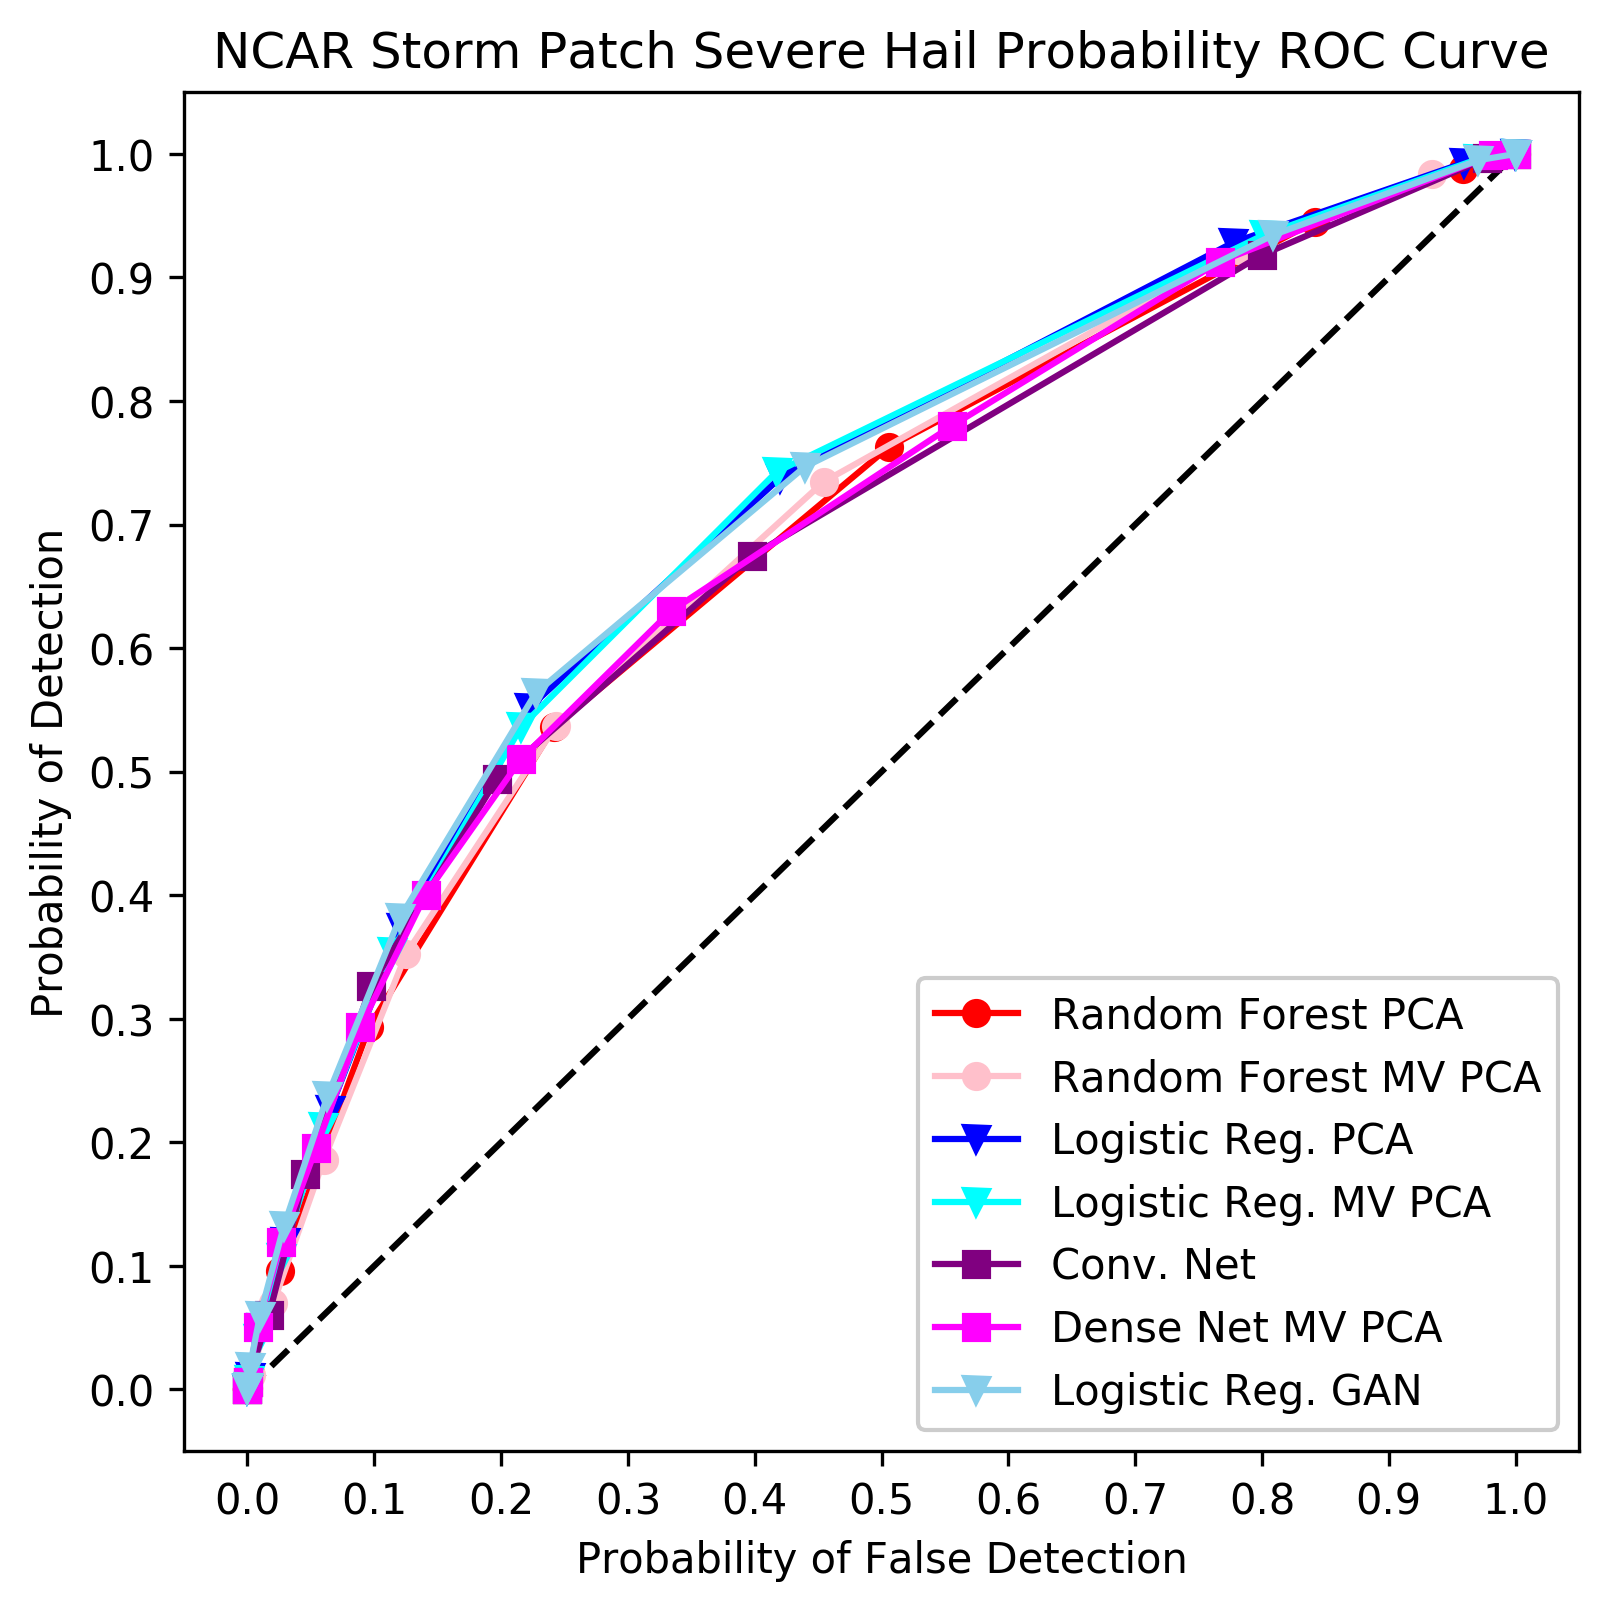

In [559]:
Image("/scratch/dgagne/hail_models/hail_prob_roc.png", width=500)

In [560]:
attributes_diagram(rel_list, ml_model_names,
                   ml_model_colors, ml_model_symbols, "/scratch/dgagne/hail_models/hail_prob_rel.png", figsize=(6, 6), 
                      title="NCAR Storm Patch Severe Hail Probability Reliability")

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


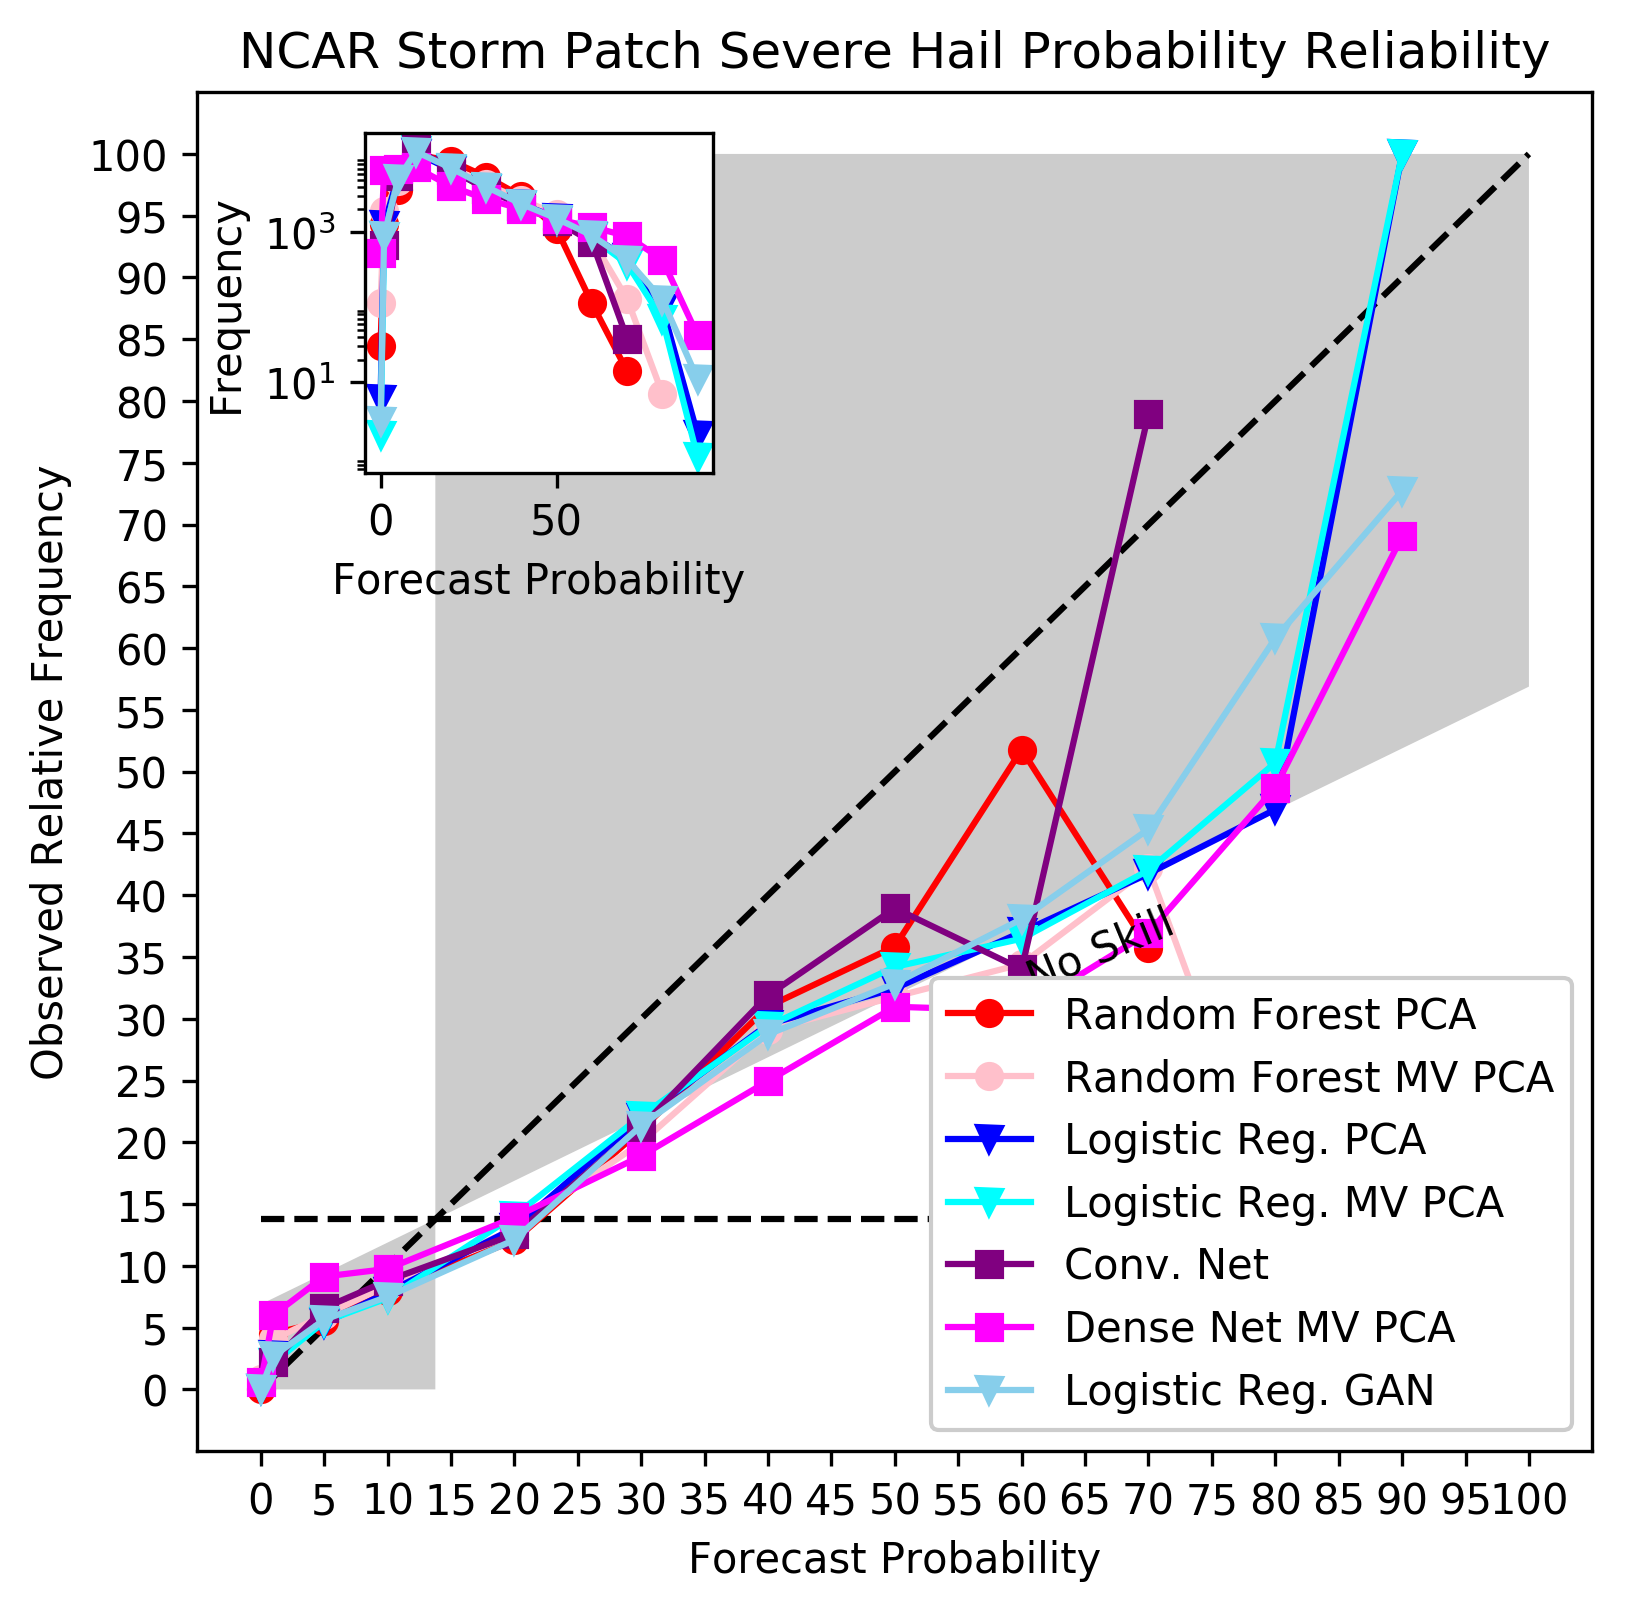

In [561]:
Image("/scratch/dgagne/hail_models/hail_prob_rel.png", width=500)

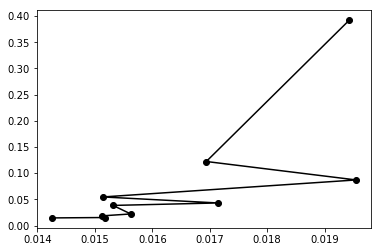

In [548]:
plt.plot(rf.feature_importances_[:10], pc_objs[0].explained_variance_ratio_, 'ko-')

In [83]:
pc_objs[0].explained_variance_ratio_

array([ 0.32953609,  0.11959258,  0.09301332,  0.05424811,  0.04212579,
        0.02868085,  0.02267651,  0.01879894,  0.01506675,  0.01394645])

In [240]:
def hail_patch_model(input_size=(32, 32, 6), filter_width=5, min_data_width=4,
                    min_conv_filters=64, stride=2):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="patch_input")
    model = None
    for c in range(num_layers):
        if c == 0:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same",
                           kernel_regularizer=l2())(image_input)
        else:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same",
                           kernel_regularizer=l2())(model)
        model = Activation("elu")(model)
        #model = BatchNormalization()(model)
        curr_conv_filters *= 2
    model = Flatten()(model)
    model = Dense(1, kernel_regularizer=l2())(model)
    model = Activation("sigmoid")(model)
    return model, image_input

In [148]:
storm_norm_data = np.zeros(storm_data.shape, dtype=np.float32)
for i in range(num_vars):
    storm_norm_data[:, :, :, i] = (storm_data[:, :, :, i] - means[i]) / sds[i]

In [248]:
hail_cnn, hail_cnn_input = hail_patch_model(min_conv_filters=10, filter_width=3, min_data_width=4)
hail_cnn_model = Model(hail_cnn_input, hail_cnn)
hail_cnn_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9), loss="mse")
#hail_cnn_model.compile(optimizer="rmsprop", loss="mse")
hail_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_input (InputLayer)     (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 16, 16, 10)        550       
_________________________________________________________________
activation_99 (Activation)   (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 8, 8, 20)          1820      
_________________________________________________________________
activation_100 (Activation)  (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 4, 4, 40)          7240      
_________________________________________________________________
activation_101 (Activation)  (None, 4, 4, 40)          0         
__________

In [121]:
train_labels.mean()

4.5840985702661863

In [249]:
class_weights = class_weight.compute_class_weight("balanced", [0, 1], train_labels)
cnn_hist = hail_cnn_model.fit(storm_norm_data[train_indices],
                              train_labels, batch_size=256,
                              validation_split=0.2, epochs=20, verbose=2)

Train on 63099 samples, validate on 15775 samples
Epoch 1/20
4s - loss: 0.2811 - val_loss: 0.1469
Epoch 2/20
3s - loss: 0.1698 - val_loss: 0.1368
Epoch 3/20
3s - loss: 0.1660 - val_loss: 0.1341
Epoch 4/20
3s - loss: 0.1655 - val_loss: 0.1329
Epoch 5/20
3s - loss: 0.1653 - val_loss: 0.1342
Epoch 6/20
3s - loss: 0.1652 - val_loss: 0.1368
Epoch 7/20
3s - loss: 0.1652 - val_loss: 0.1364
Epoch 8/20
3s - loss: 0.1652 - val_loss: 0.1383
Epoch 9/20
3s - loss: 0.1651 - val_loss: 0.1334
Epoch 10/20
3s - loss: 0.1654 - val_loss: 0.1355
Epoch 11/20
3s - loss: 0.1651 - val_loss: 0.1353
Epoch 12/20
3s - loss: 0.1651 - val_loss: 0.1361
Epoch 13/20
3s - loss: 0.1650 - val_loss: 0.1335
Epoch 14/20
3s - loss: 0.1652 - val_loss: 0.1324
Epoch 15/20
3s - loss: 0.1650 - val_loss: 0.1352
Epoch 16/20
3s - loss: 0.1650 - val_loss: 0.1338
Epoch 17/20
3s - loss: 0.1652 - val_loss: 0.1334
Epoch 18/20
3s - loss: 0.1652 - val_loss: 0.1345
Epoch 19/20
3s - loss: 0.1650 - val_loss: 0.1328
Epoch 20/20
3s - loss: 0.164

(15775, 32, 32, 6)

In [250]:
cnn_preds = hail_cnn_model.predict(storm_norm_data[test_indices])[:, 0]

(array([  4578.,  10741.,   7263.,   4158.,   2651.,   1800.,   1292.,
          1012.,    637.,    106.]),
 array([ 0.0085318 ,  0.08866124,  0.16879068,  0.24892012,  0.32904956,
         0.409179  ,  0.48930844,  0.56943788,  0.64956732,  0.72969676,
         0.8098262 ]),
 <a list of 10 Patch objects>)

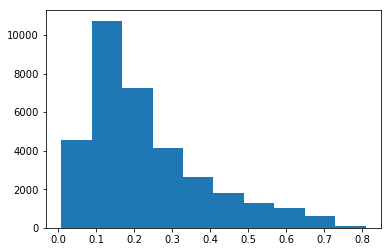

In [244]:
plt.hist(cnn_preds)

(0, 0.9)

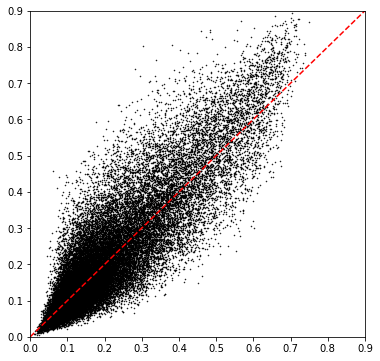

In [384]:
plt.figure(figsize=(6,6))
plt.scatter(cnn_preds, logit_preds, 1, 'k', marker='.')
plt.plot(np.linspace(0, 0.9, 10), np.linspace(0,0.9, 10), 'r--')
plt.xlim(0, 0.9)
plt.ylim(0, 0.9)

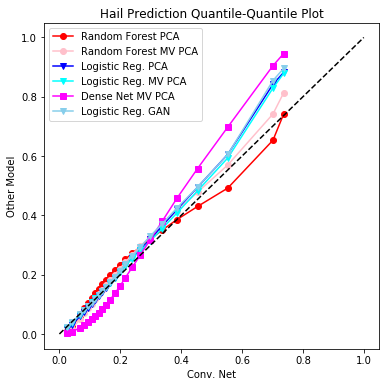

In [549]:
plt.figure(figsize=(6, 6))
quantiles = np.concatenate([[0.1], np.arange(1, 100, 5), [99.9, 99.99]])
for m, model in enumerate(pred_frame.columns):
    if model != ref_model:
        plt.plot(np.percentile(pred_frame[ref_model], quantiles), 
                 np.percentile(pred_frame[model], quantiles), marker=ml_model_symbols[m], linestyle="-", 
                 color=ml_model_colors[m], label=model)
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10),'k--')
plt.legend()
plt.xlabel(ref_model)
plt.ylabel("Other Model")
plt.title("Hail Prediction Quantile-Quantile Plot")
plt.savefig("/scratch/dgagne/hail_models/hail_model_qq_plot.png", dpi=250, bbox_inches="tight")

In [267]:
ann_input = Input(shape=(mv_pc_train_data.shape[1], ))
ann_model = Dense(64, kernel_regularizer=l2())(ann_input)
ann_model = Activation("elu")(ann_model)
ann_model = Dense(64, kernel_regularizer=l2())(ann_model)
ann_model = Activation("elu")(ann_model)
ann_model = Dense(1)(ann_model)
ann_model = Activation("sigmoid")(ann_model)
ann_obj = Model(ann_input, ann_model)
ann_obj.compile(optimizer=Adam(lr=0.001, beta_1=0.9), loss="mse")
ann_obj.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                1024      
_________________________________________________________________
activation_103 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_104 (Activation)  (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
_________________________________________________________________
activation_105 (Activation)  (None, 1)                 0         
Total para

In [269]:
ann_hist = ann_obj.fit(mv_pc_train_data,
                       train_labels, batch_size=256,
                       validation_split=0.2, epochs=20, verbose=2)

Train on 63099 samples, validate on 15775 samples
Epoch 1/20
1s - loss: 0.6233 - val_loss: 0.2753
Epoch 2/20
0s - loss: 0.2307 - val_loss: 0.1736
Epoch 3/20
0s - loss: 0.1754 - val_loss: 0.1420
Epoch 4/20
0s - loss: 0.1604 - val_loss: 0.1340
Epoch 5/20
0s - loss: 0.1547 - val_loss: 0.1287
Epoch 6/20
0s - loss: 0.1530 - val_loss: 0.1304
Epoch 7/20
0s - loss: 0.1520 - val_loss: 0.1302
Epoch 8/20
0s - loss: 0.1515 - val_loss: 0.1296
Epoch 9/20
0s - loss: 0.1513 - val_loss: 0.1265
Epoch 10/20
0s - loss: 0.1511 - val_loss: 0.1289
Epoch 11/20
0s - loss: 0.1508 - val_loss: 0.1315
Epoch 12/20
0s - loss: 0.1506 - val_loss: 0.1266
Epoch 13/20
0s - loss: 0.1510 - val_loss: 0.1366
Epoch 14/20
0s - loss: 0.1507 - val_loss: 0.1301
Epoch 15/20
0s - loss: 0.1502 - val_loss: 0.1268
Epoch 16/20
0s - loss: 0.1505 - val_loss: 0.1342
Epoch 17/20
0s - loss: 0.1503 - val_loss: 0.1271
Epoch 18/20
0s - loss: 0.1503 - val_loss: 0.1284
Epoch 19/20
0s - loss: 0.1501 - val_loss: 0.1288
Epoch 20/20
0s - loss: 0.149

In [272]:
ann_preds = ann_obj.predict(mv_pc_test_data)[:, 0]

In [293]:
400 / 5

80.0

In [431]:
hail_cnn_model.save("/scratch/dgagne/hail_models/hail_cnn.h5")

In [550]:
gan_encoder = load_model("/scratch/dgagne/storm_gan_20170622/gan_encoder_000004_epoch_0010.h5")

In [466]:
scaled_storm_data = rescale_multivariate_data(storm_data)

In [551]:
gan_encoded_data = gan_encoder.predict(scaled_storm_data)

In [566]:
gan_rf = RandomForestClassifier(n_estimators=500, n_jobs=2, max_features="sqrt")
gan_rf.fit(gan_encoded_data[train_indices], train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [552]:
gan_logit = LogisticRegression(penalty="l1", C=1.0)
gan_logit.fit(gan_encoded_data[train_indices], train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [553]:
gan_logit_preds = gan_logit.predict_proba(gan_encoded_data[test_indices])[:, 1]

In [474]:
gan_config = pd.read_csv("/scratch/dgagne/storm_gan_20170622/gan_param_combos.csv")
gan_config

,Index,min_data_width,filter_width,beta_one,min_conv_filters,generator_input_size,learning_rate,batch_size
0,0,4,5,0.2,64,16,0.0001,256
1,1,4,5,0.2,64,32,0.0001,256
2,2,4,5,0.2,64,128,0.0001,256
3,3,4,5,0.2,128,16,0.0001,256
4,4,4,5,0.2,128,32,0.0001,256
5,5,4,5,0.2,128,128,0.0001,256


In [538]:
gan_logit.coef_

array([[ 0.38990883,  0.05266437, -0.03433617,  0.28076406,  0.00533482,
        -0.03467138,  0.1286665 ,  0.13257392, -0.15371283, -0.2921469 ,
         0.31680332, -0.09667652, -0.06481077,  0.08604042, -0.17793716,
         0.31835279, -0.18484134,  0.2588846 , -0.19481517,  0.04200378,
        -0.09355052,  0.08315428, -0.30006542, -0.2830448 ,  0.07425156,
         0.3472813 , -0.01682743, -0.41206255, -0.03509778,  0.14562221,
         0.10760665,  0.0872685 ]])

In [502]:
svc_gan = SVC()
svc_gan.fit(gan_encoded_data[train_indices], train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [503]:
svc_gan_preds = svc_gan.predict(gan_encoded_data[test_indices])

In [565]:
gan_encoded_data

array([[-0.34008276,  1.19715524, -0.63513237, ..., -0.14991538,
        -0.60912448, -0.68301642],
       [-0.51168543, -0.20728123, -0.43839157, ..., -0.25434551,
        -0.87436426, -0.00490863],
       [-0.25327265,  0.0642819 , -0.81532574, ..., -0.24091433,
        -0.84921199,  0.47695681],
       ..., 
       [ 0.46007439,  1.14880955,  0.09934964, ..., -0.95305496,
        -0.96046227, -0.9099921 ],
       [-0.12138393,  0.08391103,  0.36366069, ...,  1.07707536,
        -0.95905358, -0.06669842],
       [-0.23752837, -0.07356223,  0.40274957, ...,  0.06267218,
        -1.38020968, -0.28596163]], dtype=float32)

In [534]:
32 * 32 * 6

6144

In [569]:
import tensorflow as tf
a = tf.Variable(1.0, name="a")
b = tf.Variable(2.0, name="b")
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)
sess.run(a +b )

3.0

(array([ 11.,   9.,   3.,   2.,   4.,   1.,   0.,   0.,   1.,   1.]),
 array([ 0.0266874 ,  0.02863048,  0.03057356,  0.03251664,  0.03445972,
         0.0364028 ,  0.03834588,  0.04028896,  0.04223204,  0.04417512,
         0.0461182 ]),
 <a list of 10 Patch objects>)

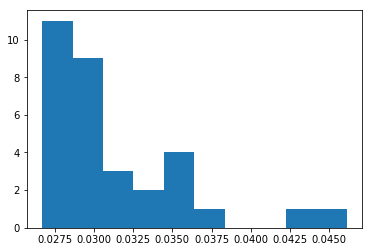

In [575]:
plt.hist(gan_rf.feature_importances_)

In [580]:
gan_rocs = []
gan_rels = []
for gan_config in range(0, 6):
    print(gan_config)
    gan_encoder_c = load_model("/scratch/dgagne/storm_gan_20170622/gan_encoder_00000{0:d}_epoch_0010.h5".format(gan_config))
    gan_encoded_data_c = gan_encoder_c.predict(scaled_storm_data)
    gan_logit_c = LogisticRegression(penalty="l2")
    gan_logit_c.fit(gan_encoded_data_c[train_indices], train_labels)
    gan_logit_preds_c = gan_logit_c.predict_proba(gan_encoded_data_c[test_indices])[:, 1]
    gan_rocs.append(DistributedROC(thresholds=thresholds))
    gan_rocs[-1].update(gan_logit_preds_c, test_labels)
    gan_rels.append(DistributedReliability(thresholds=thresholds))
    gan_rels[-1].update(gan_logit_preds_c, test_labels)
    print(gan_config, gan_rocs[-1].auc(), gan_rels[-1].brier_score())

0
0 0.700809896748 0.117428053625
1
1 0.710081881423 0.115780810795
2
2 0.71100853813 0.120186961855
3
3 0.706824307868 0.116852251884
4
4 0.711710993327 0.115223494363
5
5 0.704650066589 0.117800195689


In [582]:
gan_kmeans = KMeans()
gan_clusters = gan_kmeans.fit_predict(gan_encoded_data)

In [588]:
for cluster in gan_kmeans.cluster_centers_:
    print(np.argmin(np.mean(np.abs(gan_encoded_data - cluster), axis=1)))

80779
20117
55808
90096
97478
50437
28946
2813


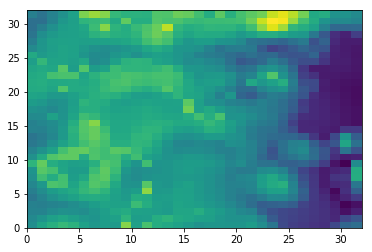

In [594]:
plt.pcolormesh(storm_data[50437, :, :, 0])